In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import timm
import torch.nn as nn
from torch.utils.data import DataLoader  # DataLoaderのインポート

In [2]:
# データのパス
data_dir = './images2/'

# データ前処理
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# データセットを読み込む
image_datasets = {x: datasets.ImageFolder(root=f'{data_dir}/{x}', transform=data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


In [3]:
model = timm.create_model('vit_base_patch32_224', pretrained=True)

# 最後の全結合層をカスタムクラス数に変更
num_ftrs = model.head.in_features  # DenseNetでは `classifier`が最終層
model.head = nn.Linear(num_ftrs, len(class_names))  # クラス数に合わせて変更

# モデルをデバイスに転送
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [4]:
# 畳み込み層の重みを固定（勾配計算を行わないようにする）
for param in model.parameters():
    param.requires_grad = False

# 最後の全結合層だけ勾配計算を有効にする
for param in model.head.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()  # 損失関数
optimizer = optim.Adam(model.head.parameters(), lr=0.001)  # 最後の層だけ最適化

num_epochs = 100

# 各エポックでトレーニングとバリデーションを行う
for epoch in range(num_epochs):
    train_loss = 0.0
    train_corrects = 0
    val_loss = 0.0
    val_corrects = 0

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # トレーニングモード
        else:
            model.eval()  # 評価モード

        running_loss = 0.0
        running_corrects = 0

        # データローダーからバッチを取り出して学習
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配を初期化
            optimizer.zero_grad()

            # 順伝播と逆伝播（トレーニング時のみ）
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # ロスと正解数を更新
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        # 各フェーズの損失と精度を一時的に保持
        if phase == 'train':
            train_loss = epoch_loss
            train_acc = epoch_acc
        else:
            val_loss = epoch_loss
            val_acc = epoch_acc

    # エポックごとにトレーニングとバリデーションの情報を一行で表示
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

print("Training complete")


Epoch [1/100], Train Loss: 0.7612, Train Accuracy: 0.4111, Val Loss: 0.7015, Val Accuracy: 0.5000
Epoch [2/100], Train Loss: 0.7258, Train Accuracy: 0.5000, Val Loss: 0.6825, Val Accuracy: 0.6000
Epoch [3/100], Train Loss: 0.6969, Train Accuracy: 0.5333, Val Loss: 0.6469, Val Accuracy: 0.6000
Epoch [4/100], Train Loss: 0.6440, Train Accuracy: 0.5889, Val Loss: 0.6261, Val Accuracy: 0.7000
Epoch [5/100], Train Loss: 0.6162, Train Accuracy: 0.6556, Val Loss: 0.6143, Val Accuracy: 0.6000
Epoch [6/100], Train Loss: 0.5850, Train Accuracy: 0.6444, Val Loss: 0.5889, Val Accuracy: 0.6000
Epoch [7/100], Train Loss: 0.5650, Train Accuracy: 0.6667, Val Loss: 0.5688, Val Accuracy: 0.7000
Epoch [8/100], Train Loss: 0.5462, Train Accuracy: 0.7000, Val Loss: 0.5671, Val Accuracy: 0.6000
Epoch [9/100], Train Loss: 0.5406, Train Accuracy: 0.7111, Val Loss: 0.5948, Val Accuracy: 0.6000
Epoch [10/100], Train Loss: 0.5208, Train Accuracy: 0.7444, Val Loss: 0.5248, Val Accuracy: 0.7000
Epoch [11/100], Tra

In [5]:
#torch.save(model.state_dict(), 'DenseNet-201_images1.pth')


Test Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


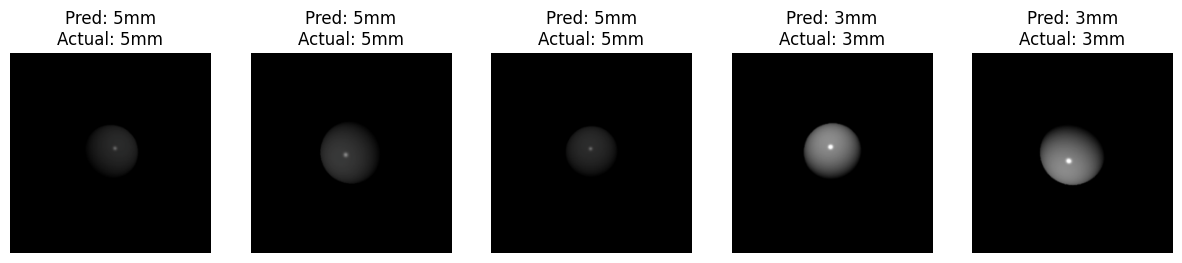

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score

# デバイス設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# テストデータの前処理
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# テストデータセットを読み込む
test_dataset = datasets.ImageFolder(root='./images_test/', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# テストデータセットのサイズを取得
test_dataset_size = len(test_dataset)

model.eval()  # 評価モードに設定

running_corrects = 0
all_preds = []
all_labels = []
all_images = []

# テストデータを使って評価
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # 順伝播のみ（勾配計算は不要）
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # 最も高いスコアのクラスを予測

    # 正解数をカウント
    running_corrects += torch.sum(preds == labels.data)

    # 画像、予測結果、ラベルをリストに保存
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    all_images.extend(inputs.cpu().numpy().transpose(0, 2, 3, 1))  # (N, C, H, W) -> (N, H, W, C)

# 精度を計算
accuracy = running_corrects.double() / test_dataset_size
print(f'Test Accuracy: {accuracy:.4f}')

# 精度、再現率、F1スコアの計算
precision = precision_score(all_labels, all_preds, average='weighted')  # 各クラスの精度の加重平均
recall = recall_score(all_labels, all_preds, average='weighted')  # 各クラスの再現率の加重平均
f1 = f1_score(all_labels, all_preds, average='weighted')  # 各クラスのF1スコアの加重平均

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# ランダムに5つの画像を選択して表示
n_images = 5
plt.figure(figsize=(15, 10))
indices = random.sample(range(len(all_images)), n_images)
class_names = test_dataset.classes
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for i, idx in enumerate(indices):
    image = all_images[idx]
    image = std * image + mean  # 標準化を元に戻す
    image = np.clip(image, 0, 1)  # 値を [0, 1] に制限

    pred_label = class_names[all_preds[idx]]
    actual_label = class_names[all_labels[idx]]

    plt.subplot(1, n_images, i + 1)
    plt.imshow(image)
    plt.title(f'Pred: {pred_label}\nActual: {actual_label}')
    plt.axis('off')

plt.show()


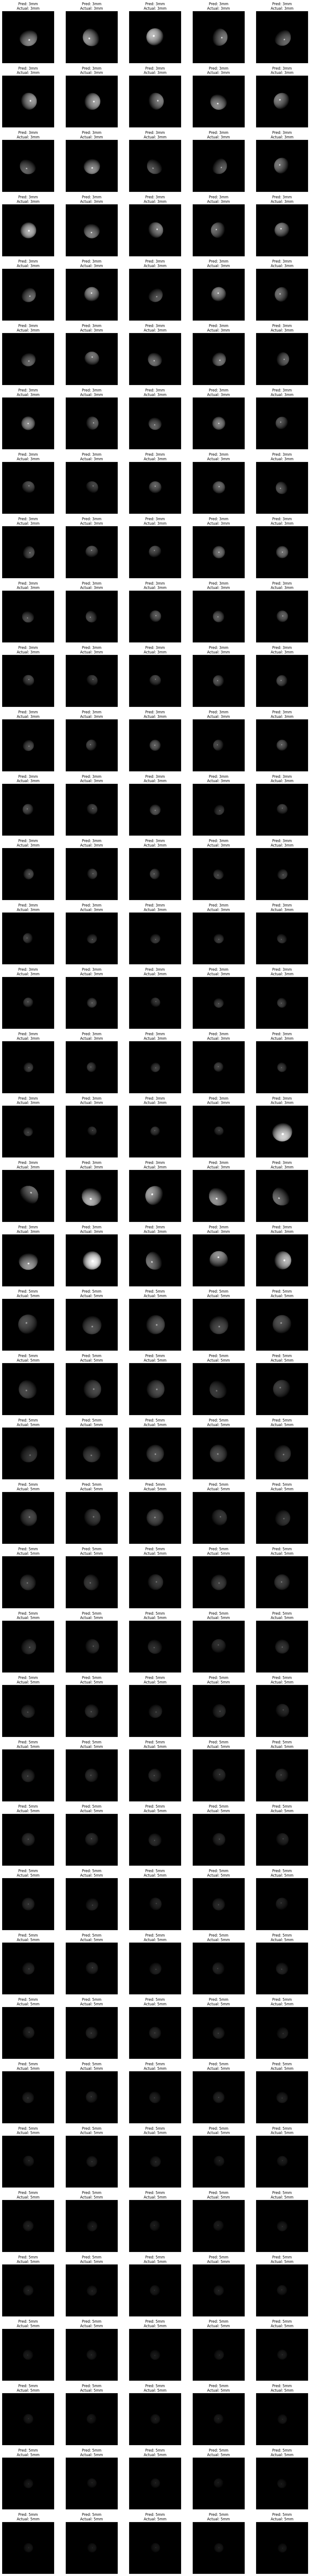

In [7]:
import math
import matplotlib.pyplot as plt
import numpy as np

# グリッドサイズの設定
n_images = len(all_images)
grid_cols = 5  # 1行に表示する画像の数
grid_rows = math.ceil(n_images / grid_cols)

plt.figure(figsize=(15, 3 * grid_rows))  # 全体のサイズを調整
class_names = test_dataset.classes

# 標準化解除用の平均と標準偏差
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for i, idx in enumerate(range(n_images)):
    image = all_images[idx]  # (H, W, C) の形式
    image = std * image + mean  # 標準化を元に戻す
    image = np.clip(image, 0, 1)  # 値を [0, 1] に制限

    pred_label = class_names[all_preds[idx]]
    actual_label = class_names[all_labels[idx]]

    plt.subplot(grid_rows, grid_cols, i + 1)
    plt.imshow(image)
    plt.title(f'Pred: {pred_label}\nActual: {actual_label}')
    plt.axis('off')

plt.tight_layout()  # レイアウト調整
plt.show()
